This code snippet sets up the environment for medical image segmentation using PyTorch and U-Net.

- **Imports**: It begins by importing essential libraries, including `numpy` for numerical operations, `cv2` for image processing, and `torch` for deep learning operations. Additional imports like `matplotlib` are used for visualizations, while `PIL` is used for handling images.
- **Warnings Suppression**: The code defines a custom function `warn` that does nothing, effectively suppressing all warnings that might clutter the output. This is particularly useful in a research setting where repeated warnings can distract from the analysis.
- **Importance**: By organizing the necessary libraries and suppressing unnecessary warnings, this code prepares a clean workspace for implementing and testing medical image segmentation models, specifically using U-Net, which is a popular architecture for this task.


In [1]:
import numpy as np
import cv2 as cv
import zipfile
import io
import requests
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from PIL import Image

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')


1. **URL Definition**:
   The code starts by defining the URL to a ZIP file containing the dataset. This URL will be used to download the data needed for training and testing.

2. **Normalization Function**:
   The `normalize` function scales image pixel values from the range [0, 255] to [0, 1]. This normalization is important to ensure that pixel values are in a consistent range suitable for neural network training.

3. **Center Crop Function**:
   The `center_crop` function extracts a central region of the image with specified dimensions. This is useful for focusing on the central part of the image, which is often the most relevant for medical image analysis.

4. **Shape Processing Function**:
   The `shape_process` function handles resizing and padding of images. It resizes images to half their original size if their dimensions are odd and pads them to fit a specific input size. This step ensures that all images have the same dimensions, which is crucial for batch processing in neural networks.

5. **Download and Unzip**:
   The code downloads the ZIP file from the defined URL and reads it into a `BytesIO` object. This prepares the data for extraction and further processing.

6. **Image and Label Processing**:
   Within the ZIP file, images are categorized into training images, training labels, and test images. The code processes these images by normalizing, resizing, and cropping them as needed. Training labels are converted to binary masks to facilitate segmentation tasks. This preprocessing ensures that the data is in the correct format for training and evaluating the U-Net model.

7. **Array Conversion**:
   After processing, images and labels are converted into NumPy arrays with floating-point data types and reshaped to include a channel dimension. This formatting aligns the data with the input requirements of the U-Net model, ensuring compatibility during training and inference.


In [2]:
# Define the link to the ZIP file
zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/o_kRuP_Bk_Pa2xvo1ly63w/data.zip'


def normalize(image):
    return np.array(image) / 255.0


def center_crop(img, output_size):

    img = np.array(img)

    start_y = (img.shape[0] - output_size[0]) // 2
    start_x = (img.shape[1] - output_size[1]) // 2

    cropped_img = img[start_y:start_y + output_size[0], start_x:start_x + output_size[1]]
    return cropped_img


def shape_process(img, input_size):

    if img.shape[0] % 2:
        img = cv.resize(img, img.shape[0] // 2, interpolation=cv.INTER_CUBIC)
    padd = int((input_size[0] - img.shape[0]) / 2)
    img = cv.copyMakeBorder(img, padd, padd, padd, padd, cv.BORDER_REFLECT_101)

    return img


# Download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# Initialize lists to hold images and labels
test_images = []
train_labels = []
train_images = []

with zipfile.ZipFile(zip_file_bytes, 'r') as zip_ref:
    sorted_files = sorted(zip_ref.namelist())
    for file_name in sorted_files:
        if file_name.endswith('.tif'):
            with zip_ref.open(file_name) as file:
                img = Image.open(file).convert('L')  # Convert to grayscale
                img = np.array(img)
                if '/train/images/' in file_name:
                    train_images.append(normalize(shape_process(img, (572, 572))))
                elif '/train/labels/' in file_name:
                    cropped_img = center_crop(img, (388, 388))
                    normalized_img = normalize(cropped_img)
                    mask = (normalized_img > 0.5).astype(int)
                    train_labels.append(mask)
                elif '/test/' in file_name:
                    test_images.append(normalize(shape_process(img, (572, 572))))

    train_images = np.asarray(train_images, dtype=np.float32)
    # [N, H, W, C]
    train_images = train_images[:, :, :, np.newaxis]

    test_images = np.asarray(test_images, dtype=np.float32)
    test_images = test_images[:, :, :, np.newaxis]

    train_labels = np.asarray(train_labels, dtype=np.float32)
    train_labels = train_labels[:, :, :, np.newaxis]

The following code prints the shapes of the `train_images`, `train_labels`, and `test_images` arrays:

1. **Train Images Shape**:
   ```python
   print(f'train_images.shape: {train_images.shape}')


In [3]:
print(f'train_images.shape: {train_images.shape}')
print(f'train_labels.shape: {train_labels.shape}')
print(f'test_images.shape: {test_images.shape}')

train_images.shape: (30, 572, 572, 1)
train_labels.shape: (30, 388, 388, 1)
test_images.shape: (30, 572, 572, 1)


#Image Meaning
###Left Image:
A training image from the dataset, showing a high-resolution transmission electron microscopy (TEM) image of the Drosophila first instar larva ventral nerve cord (VNC). The detailed structures represent the cellular and subcellular components of neuronal tissue.

###Right Image:
The ground truth annotation for the left image, depicted as a binary mask:

White areas: Segmented neuronal structures.
Black areas: Non-neuronal structures, primarily cell membranes and other components.

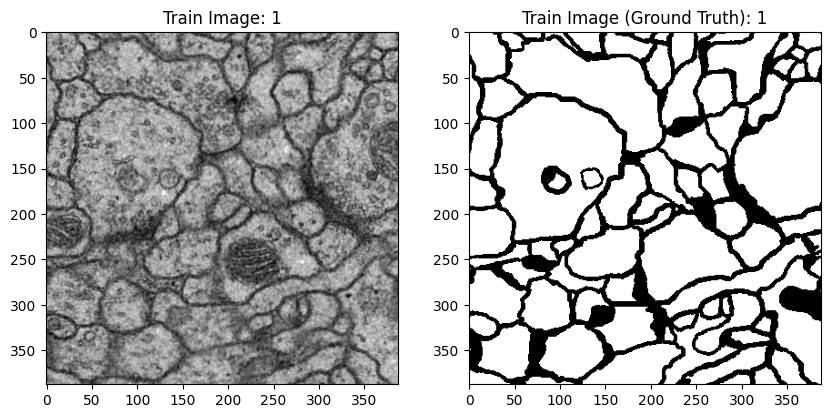

In [4]:
sample_image_index = 1

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(center_crop(train_images[sample_image_index], (388, 388))), cmap='gray')
plt.title(f'Train Image: {sample_image_index}')
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(train_labels[sample_image_index]), cmap='gray')
plt.title(f'Train Image (Ground Truth): {sample_image_index}')
plt.show()


1. **Initialization (`__init__` Method)**:
   - **Convolutional Layers**: The U-Net model starts with a series of convolutional blocks, each consisting of two convolutional layers followed by ReLU activations. The network gradually increases the number of feature channels in each layer to capture more complex features.
   - **Pooling Layers**: Max pooling layers are used to downsample the feature maps, reducing their spatial dimensions while increasing the depth.
   - **Upsampling Layers**: Transposed convolutional layers (also known as up-convolution or deconvolution) are used to upsample the feature maps, increasing their spatial dimensions to match the original image size.
   - **Skip Connections**: The architecture includes skip connections between the downsampling and upsampling paths. These connections concatenate feature maps from the downsampling path with those from the upsampling path, preserving fine details and improving segmentation accuracy.
   - **Final Convolution**: A 1x1 convolutional layer at the end reduces the number of output channels to 1, producing a single-channel output map.

2. **Double Convolution Block (`double_conv` Method)**:
   - This method defines a sequence of two convolutional layers with ReLU activations. Each convolutional layer has a kernel size of 3 and no padding, which helps in capturing local features and ensuring the spatial dimensions decrease appropriately.

3. **Center Crop (`center_crop` Method)**:
   - The `center_crop` method crops the central region of a tensor to match a target shape. This is used to align feature maps from different layers when concatenating them during the upsampling process.

4. **Forward Pass (`forward` Method)**:
   - **Downsampling Path**: The input image passes through the series of convolutional and pooling layers, gradually reducing the spatial dimensions while increasing the depth.
   - **Bottleneck**: The bottleneck layer applies additional convolutions without downsampling, capturing high-level features.
   - **Upsampling Path**: The feature maps are upsampled using transposed convolutions. Each upsampling step concatenates feature maps from the corresponding downsampling step to retain detailed information.
   - **Output Layer**: The final convolutional layer produces the output segmentation map, which is passed through a sigmoid activation function to generate probabilities for binary classification.

Overall, this U-Net implementation is designed for precise segmentation tasks by leveraging an encoder-decoder architecture with skip connections, making it well-suited for medical image segmentation where detail preservation is critical.


In [5]:
from torch import nn


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.conv1 = self.double_conv(1, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = self.double_conv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        # concat conv4 + up_conv1
        self.conv6 = self.double_conv(512 + 512, 512)

        self.up_conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        # concat conv4 + up_conv1
        self.conv6 = self.double_conv(512 + 512, 512)

        self.up_conv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        # concat conv3 + up_conv2
        self.conv7 = self.double_conv(256 + 256, 256)

        self.up_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        # concat conv2 + up_conv3
        self.conv8 = self.double_conv(128 + 128, 128)

        self.up_conv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        # concat conv1 + up_conv4
        self.conv9 = self.double_conv(64 + 64, 64)

        self.conv10 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True)
        )

    def center_crop(self, source_tensor, target_shape):
        start_y = (source_tensor.shape[2] - target_shape[2]) // 2
        start_x = (source_tensor.shape[3] - target_shape[3]) // 2

        return source_tensor[:, :, start_y:start_y + target_shape[2], start_x:start_x + target_shape[3]]

    def forward(self, x):
        # Downsampling path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        x = self.conv5(p4)

        x = self.up_conv1(x)
        x = torch.cat((self.center_crop(c4, x.shape), x), dim=1)
        x = self.conv6(x)

        x = self.up_conv2(x)
        x = torch.cat((self.center_crop(c3, x.shape), x), dim=1)
        x = self.conv7(x)

        x = self.up_conv3(x)
        x = torch.cat((self.center_crop(c2, x.shape), x), dim=1)
        x = self.conv8(x)

        x = self.up_conv4(x)
        x = torch.cat((self.center_crop(c1, x.shape), x), dim=1)
        x = self.conv9(x)

        output = torch.sigmoid(self.conv10(x))

        return output

In [6]:
model = UNet()
print(model)

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d

In [7]:
input_tensor = torch.randn(1, 1, 572, 572)


def print_size(module, input, output):
    print(f"{module.__class__.__name__} output size: {output.size()}")


for layer in model.children():
    layer.register_forward_hook(print_size)


with torch.no_grad():
    output = model(input_tensor)

print("Final output size:", output.size())

Sequential output size: torch.Size([1, 64, 568, 568])
MaxPool2d output size: torch.Size([1, 64, 284, 284])
Sequential output size: torch.Size([1, 128, 280, 280])
MaxPool2d output size: torch.Size([1, 128, 140, 140])
Sequential output size: torch.Size([1, 256, 136, 136])
MaxPool2d output size: torch.Size([1, 256, 68, 68])
Sequential output size: torch.Size([1, 512, 64, 64])
MaxPool2d output size: torch.Size([1, 512, 32, 32])
Sequential output size: torch.Size([1, 1024, 28, 28])
ConvTranspose2d output size: torch.Size([1, 512, 56, 56])
Sequential output size: torch.Size([1, 512, 52, 52])
ConvTranspose2d output size: torch.Size([1, 256, 104, 104])
Sequential output size: torch.Size([1, 256, 100, 100])
ConvTranspose2d output size: torch.Size([1, 128, 200, 200])
Sequential output size: torch.Size([1, 128, 196, 196])
ConvTranspose2d output size: torch.Size([1, 64, 392, 392])
Sequential output size: torch.Size([1, 64, 388, 388])
Conv2d output size: torch.Size([1, 1, 388, 388])
Final output si

In [10]:
import torch

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This code snippet outlines the steps for preparing data for training and validating a neural network model using PyTorch:

1. **Convert Data to Tensors**:
   - The training images and labels are converted from NumPy arrays to PyTorch tensors and reshaped to match the format expected by the model. This conversion includes moving the tensors to the appropriate computing device (CPU or GPU) and ensuring they are in float format.

2. **Create Dataset**:
   - A `TensorDataset` is created to pair the images and labels together. This dataset structure helps in managing and accessing data samples and their corresponding labels.

3. **Set Random Seed**:
   - A random seed is set to ensure that the data splitting process is reproducible. This means that each run of the code will produce the same data splits, allowing for consistent results.

4. **Split Dataset**:
   - The dataset is divided into training and validation sets. Typically, a percentage of the data (e.g., 80%) is allocated for training, while the remaining portion (e.g., 20%) is used for validation. This split allows for model training and evaluation on separate data.

5. **Create DataLoaders**:
   - `DataLoader` instances are created for both the training and validation datasets. These loaders handle batching, shuffling (for training), and efficient data loading during model training and evaluation. Shuffling is used to ensure that the training data is presented in a random order, which helps in improving model generalization.

Overall, these steps prepare and organize the data to be efficiently used in the training and validation of a neural network model.


In [11]:
from torch.utils.data import DataLoader, TensorDataset, random_split

batch_size = 1

train_tensor = torch.from_numpy(train_images[:6]).permute(0, 3, 1, 2).float().to(device)
train_groundtruth_tensor = torch.from_numpy(train_labels[:6]).permute(0, 3, 1, 2).float().to(device)

dataset = TensorDataset(train_tensor, train_groundtruth_tensor)

torch.manual_seed(42)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


This code snippet outlines the process of training and validating a U-Net model for image segmentation, followed by plotting the training and validation losses. Here are the steps:

1. **Define Intersection over Union (IoU) Score Function**:
   - An IoU score function is defined to evaluate the model’s performance. It calculates the Intersection over Union (IoU) metric, which measures the overlap between the predicted and ground truth segmentation masks. The function uses a small smoothing factor to avoid division by zero.

2. **Initialize Model and Optimizer**:
   - An instance of the U-Net model is created and moved to the specified device (CPU or GPU).
   - The Adam optimizer is initialized to update the model’s parameters with a learning rate of 0.0001.

3. **Training and Validation Loop**:
   - The training loop iterates over the specified number of epochs (50). For each epoch:
     - **Training Phase**:
       - The model is set to training mode.
       - For each batch in the training dataset:
         - The gradients are zeroed.
         - The model makes predictions, and the binary cross-entropy loss is computed.
         - The gradients are calculated through backpropagation, and the optimizer updates the model’s parameters.
         - The loss and IoU score are accumulated for the epoch.
       - Average training loss and accuracy are calculated and stored.
     - **Validation Phase**:
       - The model is set to evaluation mode.
       - With gradient calculation turned off, the model makes predictions on the validation dataset.
       - The loss and IoU score are accumulated for the validation phase.
       - Average validation loss and accuracy are calculated and stored.

4. **Print Epoch Results**:
   - After each epoch, the training and validation losses and accuracies are printed to track the model’s performance over time.

5. **Plot Training and Validation Metrics**:
   - The training and validation losses are plotted over the epochs.
   - A subplot is created to visualize the losses, with separate axes for the training and validation losses. The plot helps in assessing the model’s learning progress and identifying potential overfitting or underfitting.

Overall, this code trains a U-Net model, evaluates its performance using IoU, and visualizes the learning process through loss curves.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.6010, Train Acc: 0.7440, Val Loss: 0.5893, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.6001, Train Acc: 0.7440, Val Loss: 0.5883, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.5991, Train Acc: 0.7440, Val Loss: 0.5870, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.5979, Train Acc: 0.7440, Val Loss: 0.5852, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.5958, Train Acc: 0.7440, Val Loss: 0.5822, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.5926, Train Acc: 0.7440, Val Loss: 0.5769, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.5861, Train Acc: 0.7440, Val Loss: 0.5639, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.5726, Train Acc: 0.7440, Val Loss: 0.5469, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.5683, Train Acc: 0.7440, Val Loss: 0.5471, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.5682, Train Acc: 0.7440, Val Loss: 0.5464, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.5657, Train Acc: 0.7440, Val Loss: 0.5453, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.5634, Train Acc: 0.7440, Val Loss: 0.5463, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.5625, Train Acc: 0.7440, Val Loss: 0.5430, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.5602, Train Acc: 0.7440, Val Loss: 0.5404, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.5583, Train Acc: 0.7440, Val Loss: 0.5384, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.5554, Train Acc: 0.7440, Val Loss: 0.5361, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.5522, Train Acc: 0.7440, Val Loss: 0.5323, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.5480, Train Acc: 0.7440, Val Loss: 0.5273, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.5424, Train Acc: 0.7440, Val Loss: 0.5197, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.5368, Train Acc: 0.7440, Val Loss: 0.5120, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21, Train Loss: 0.5306, Train Acc: 0.7440, Val Loss: 0.5059, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22, Train Loss: 0.5334, Train Acc: 0.7440, Val Loss: 0.5101, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23, Train Loss: 0.5226, Train Acc: 0.7440, Val Loss: 0.5017, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24, Train Loss: 0.5265, Train Acc: 0.7440, Val Loss: 0.4966, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25, Train Loss: 0.5125, Train Acc: 0.7440, Val Loss: 0.5021, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26, Train Loss: 0.5182, Train Acc: 0.7440, Val Loss: 0.4976, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27, Train Loss: 0.5170, Train Acc: 0.7440, Val Loss: 0.4908, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28, Train Loss: 0.5148, Train Acc: 0.7440, Val Loss: 0.4828, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29, Train Loss: 0.5123, Train Acc: 0.7440, Val Loss: 0.4917, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30, Train Loss: 0.5016, Train Acc: 0.7440, Val Loss: 0.4772, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31, Train Loss: 0.4972, Train Acc: 0.7440, Val Loss: 0.4763, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32, Train Loss: 0.4950, Train Acc: 0.7440, Val Loss: 0.4705, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33, Train Loss: 0.4980, Train Acc: 0.7440, Val Loss: 0.4693, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34, Train Loss: 0.4866, Train Acc: 0.7440, Val Loss: 0.4697, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35, Train Loss: 0.4872, Train Acc: 0.7440, Val Loss: 0.4758, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36, Train Loss: 0.4871, Train Acc: 0.7440, Val Loss: 0.4697, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37, Train Loss: 0.4832, Train Acc: 0.7440, Val Loss: 0.4699, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38, Train Loss: 0.4862, Train Acc: 0.7440, Val Loss: 0.4646, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39, Train Loss: 0.4836, Train Acc: 0.7440, Val Loss: 0.4705, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40, Train Loss: 0.4812, Train Acc: 0.7440, Val Loss: 0.4662, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41, Train Loss: 0.4867, Train Acc: 0.7440, Val Loss: 0.4747, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42, Train Loss: 0.4856, Train Acc: 0.7440, Val Loss: 0.4655, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43, Train Loss: 0.4816, Train Acc: 0.7440, Val Loss: 0.4761, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44, Train Loss: 0.4793, Train Acc: 0.7440, Val Loss: 0.4621, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45, Train Loss: 0.4917, Train Acc: 0.7440, Val Loss: 0.4616, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46, Train Loss: 0.4828, Train Acc: 0.7440, Val Loss: 0.4767, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47, Train Loss: 0.4805, Train Acc: 0.7440, Val Loss: 0.4619, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48, Train Loss: 0.4894, Train Acc: 0.7440, Val Loss: 0.4634, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49, Train Loss: 0.4876, Train Acc: 0.7440, Val Loss: 0.4747, Val Acc: 0.7658


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50, Train Loss: 0.4876, Train Acc: 0.7440, Val Loss: 0.4644, Val Acc: 0.7658


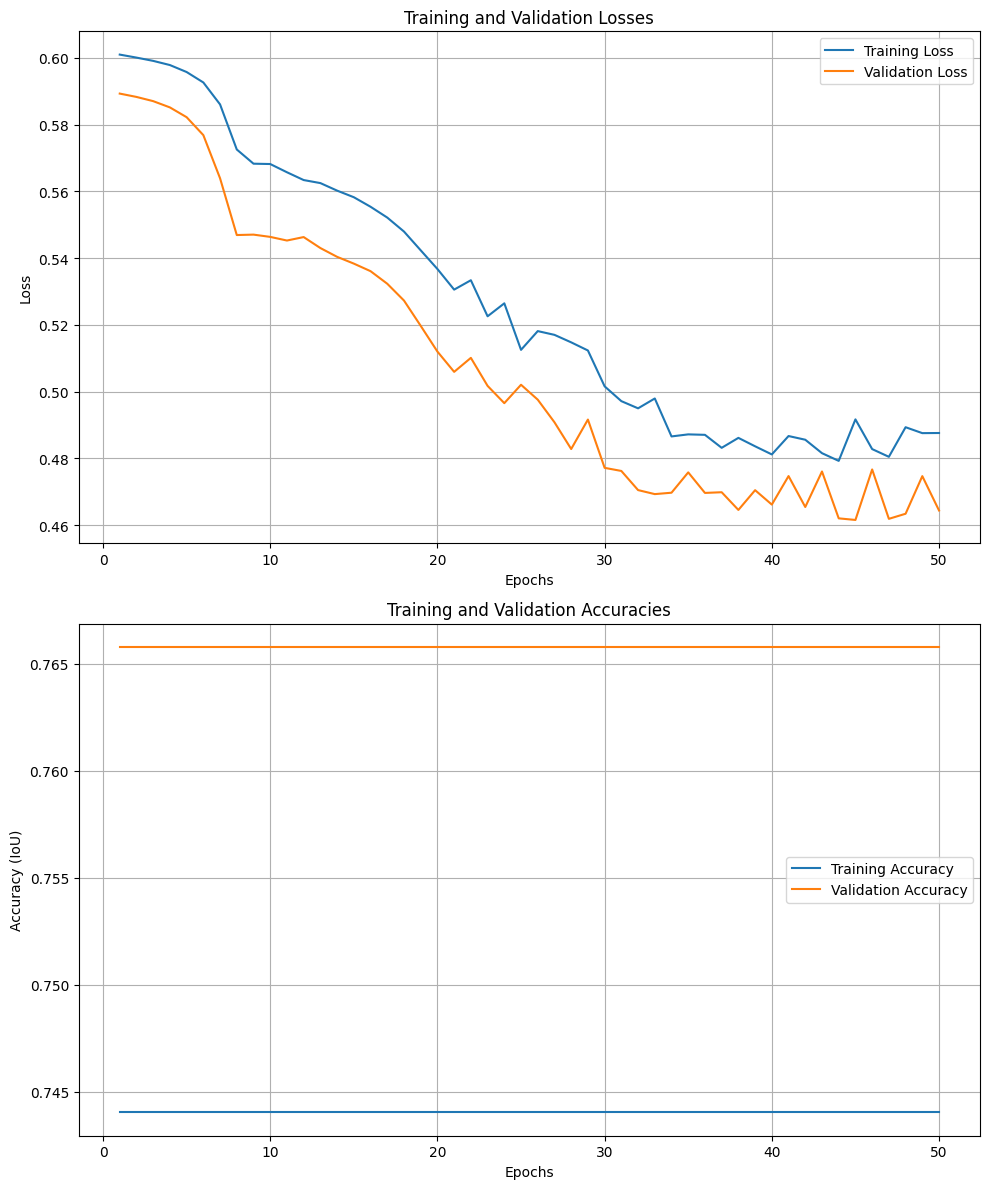

In [13]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def iou_score(output, target):
    smooth = 1e-5
    output = torch.sigmoid(output) > 0.5
    output = output.view(-1).float()
    target = target.view(-1).float()
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

model = UNet().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 50

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training and validation loop
for e in tqdm(range(epochs), leave=False, desc="Epoch"):
    model.train()
    epoch_train_loss = 0
    epoch_train_acc = 0

    for data, labels in tqdm(train_dl, leave=False, desc="   Training Dataset"):
        optim.zero_grad()
        prediction = model(data)
        loss = F.binary_cross_entropy_with_logits(prediction, labels)
        loss.backward()
        optim.step()
        epoch_train_loss += loss.item()
        epoch_train_acc += iou_score(prediction, labels).item()

    average_train_loss = epoch_train_loss / len(train_dl)
    average_train_acc = epoch_train_acc / len(train_dl)
    train_losses.append(average_train_loss)
    train_accuracies.append(average_train_acc)

    model.eval()
    epoch_val_loss = 0
    epoch_val_acc = 0
    with torch.no_grad():
        for data, labels in tqdm(val_dl, leave=False, desc="   Validation Dataset"):
            prediction = model(data)
            loss = F.binary_cross_entropy_with_logits(prediction, labels)
            epoch_val_loss += loss.item()
            epoch_val_acc += iou_score(prediction, labels).item()

    average_val_loss = epoch_val_loss / len(val_dl)
    average_val_acc = epoch_val_acc / len(val_dl)
    val_losses.append(average_val_loss)
    val_accuracies.append(average_val_acc)

    print(f"Epoch {e+1}, Train Loss: {average_train_loss:.4f}, Train Acc: {average_train_acc:.4f}, Val Loss: {average_val_loss:.4f}, Val Acc: {average_val_acc:.4f}")

# Plotting the training and validation losses and accuracies
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

ax1.plot(range(1, epochs+1), train_losses, label='Training Loss')
ax1.plot(range(1, epochs+1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Losses')
ax1.legend()
ax1.grid(True)



plt.tight_layout()
plt.show()

In [14]:
def download_pt_file(url):
    response = requests.get(url)
    return io.BytesIO(response.content)


pt_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Iu482aowoEaP9MgNqhyJ_w/model-epo300.pt'
state_dict = torch.load(download_pt_file(pt_file_url), map_location=torch.device(device))

model = UNet().to(device)
model.load_state_dict(state_dict)
model.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d

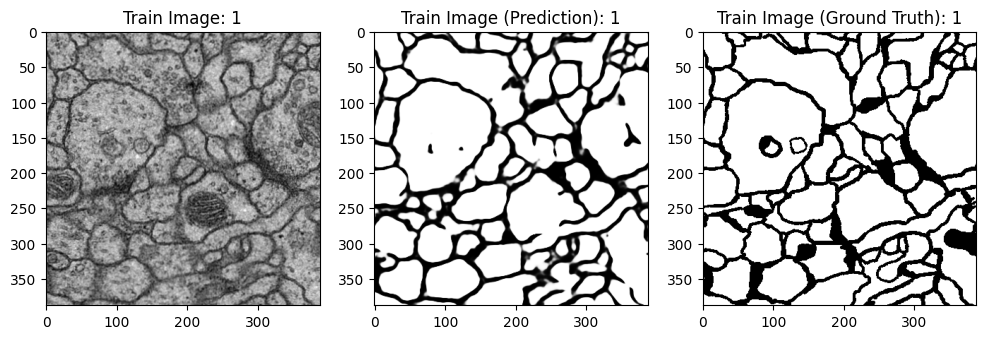

In [17]:
sample_image_index = 1

predictions = []
test_tensor = torch.from_numpy(train_images[sample_image_index]).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)

with torch.no_grad():
    prediction = model(test_tensor)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(center_crop(train_images[sample_image_index], (388, 388))), cmap='gray')
plt.title(f'Train Image: {sample_image_index}')
plt.subplot(1, 3, 2)
plt.imshow(make_grid(prediction.cpu())[0].numpy(), cmap='gray')
plt.title(f'Train Image (Prediction): {sample_image_index}')
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(train_labels[sample_image_index]), cmap='gray')
plt.title(f'Train Image (Ground Truth): {sample_image_index}')
plt.show()

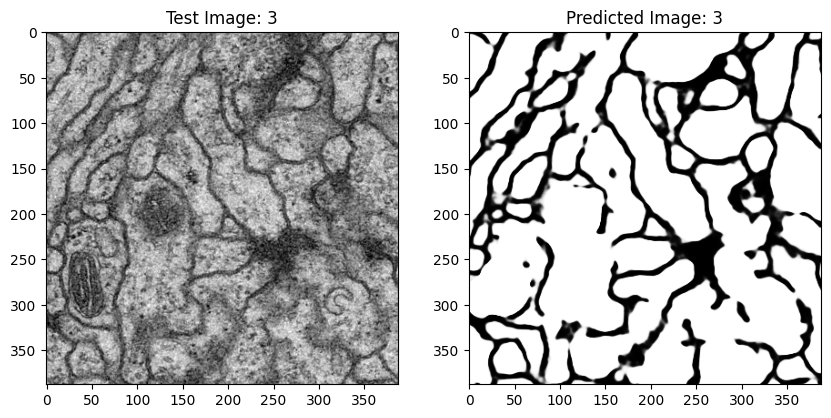

In [19]:
test_image_index = 3

predictions = []
test_tensor = torch.from_numpy(test_images[test_image_index]).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)

with torch.no_grad():
    prediction = model(test_tensor)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(center_crop(test_images[test_image_index], (388, 388))), cmap='gray')
plt.title(f'Test Image: {test_image_index}')
plt.subplot(1, 2, 2)
plt.imshow(make_grid(prediction.cpu())[0].numpy(), cmap='gray')
plt.title(f'Predicted Image: {test_image_index}')
plt.show()